## Data


In [1]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt

https://cs.stanford.edu/people/dorarad/gqa/download.html

In [2]:
question_path = os.path.join(
    os.getenv("STORAGE"),
    "datasets",
    "GQA",
    "questions"
)

In [71]:
images_path = os.path.join(
    os.getenv("STORAGE"),
    "datasets",
    "GQA",
    "images"
)

In [3]:
q_file = os.path.join(question_path, "train_balanced_questions.json")

questions = pd.read_json(q_file)

In [6]:
questions = questions.T

In [12]:
sample = questions.iloc[0]
sample

semantic       [{'operation': 'select', 'dependencies': [], '...
entailed       [02930160, 02930158, 02930159, 02930154, 02930...
equivalent                                            [02930152]
question                                        Is the sky dark?
imageId                                                  2354786
isBalanced                                                  True
groups                  {'global': None, 'local': '06-sky_dark'}
answer                                                       yes
semanticStr        select: sky (2486325)->verify color: dark [0]
annotations    {'answer': {}, 'question': {'2': '2486325'}, '...
types          {'detailed': 'verifyAttr', 'semantic': 'attr',...
fullAnswer                                 Yes, the sky is dark.
Name: 2930152, dtype: object

In [13]:
q = sample["question"]
ans = sample["answer"]
image_id = sample["imageId"]

In [20]:
image_path = os.path.join(images_path, f"{image_id}.jpg")

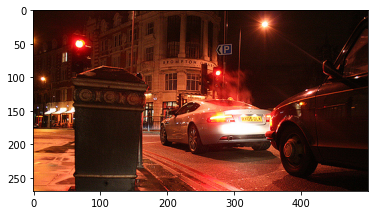

In [23]:
import numpy as np
from skimage.io import imread

image = imread(image_path)
plt.imshow(image)

In [22]:
image.shape

(270, 500, 3)

## Model

https://huggingface.co/openai/clip-vit-large-patch14-336

In [24]:
import torch
from transformers import CLIPProcessor, CLIPModel
from transformers import AutoProcessor, AutoModel

processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14-336")
model = AutoModel.from_pretrained("openai/clip-vit-large-patch14-336")

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/844 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

## Question-Image predictions

**iloc indexes are randomly picked**

### sample 1

In [26]:
q

'Is the sky dark?'

In [27]:
ans

'yes'

In [46]:
def predict(image, labels):

    inputs = processor(
        text=labels, images=image, return_tensors="pt", padding=True
    )

    
    # inference
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
    
    res = dict()
    for idx, l in enumerate(labels):
        res[l] = probs[0][idx].item()
        
    return res

In [47]:
labels = ["the sky is dark", "the sky is not dark"]

predict(image, labels)

{'the sky is dark': 0.3905278146266937,
 'the sky is not dark': 0.6094721555709839}

In [48]:
labels = ["the area is dark", "the area is not dark"]

predict(image, labels)

{'the area is dark': 0.6262500882148743,
 'the area is not dark': 0.37374991178512573}

Let's look back at the image again. Is the sky part actually visible? My personal understanding from a human perspectives is that there's barely anything called sky. A system will have to assume that it is dark and from that will have to decide if the sky is dark or not. 

That begets the question, what if it was an indoor scene? It could be dark even in daytime (even when the sky is not dark!)

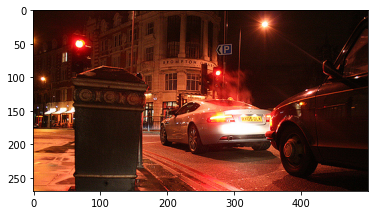

In [36]:
plt.imshow(image)

In [49]:
labels = ["it is dark", "it is not dark"]

predict(image, labels)

{'it is dark': 0.5683362483978271, 'it is not dark': 0.43166372179985046}

Let's try with more questions and images.

### sample 2

In [50]:
sample_2 = questions.iloc[4]
sample_2

semantic       [{'operation': 'select', 'dependencies': [], '...
entailed                                                      []
equivalent                                           [111007521]
question                                 Who is wearing a shirt?
imageId                                                  2331819
isBalanced                                                  True
groups         {'global': 'person', 'local': '14-shirt_wearin...
answer                                                      girl
semanticStr    select: shirt (4653737)->relate: person,wearin...
annotations    {'answer': {'0': '4653736'}, 'question': {'4':...
types          {'detailed': 'relS', 'semantic': 'rel', 'struc...
fullAnswer                          The girl is wearing a shirt.
Name: 111007521, dtype: object

In [52]:
sample_2["question"]

'Who is wearing a shirt?'

In [53]:
sample_2["answer"]

'girl'

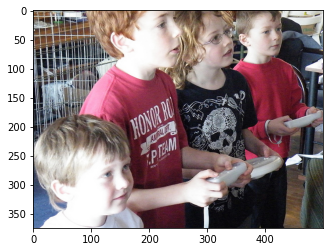

In [54]:
image_2 = imread(os.path.join(images_path, f"{sample_2['imageId']}.jpg"))
plt.imshow(image_2)

This can be a case of gender bias. (e.g. Skull tee, playing with boys etc.). Let's see if that's correct. 

In [55]:
predict(image_2, ["A girl is wearing a shirt", "A boy is wearing a shirt"])

{'A girl is wearing a shirt': 0.06855704635381699,
 'A boy is wearing a shirt': 0.9314429759979248}

Well...................

In [56]:
predict(image_2, ["A girl and three boys", "A boy and three boys"])

{'A girl and three boys': 0.1297641545534134,
 'A boy and three boys': 0.8702358603477478}

Even from a human standpoint it's hard to tell the gender here. However, the bias is here, because in an ideal system, there would've been equal probabilities for both.

### sample 3

In [57]:
sample_3 = questions.iloc[400]
sample_3

semantic       [{'operation': 'select', 'dependencies': [], '...
entailed                          [15966535, 15966534, 15966533]
equivalent                                            [15966536]
question                             On which side is the crate?
imageId                                                  2355463
isBalanced                                                  True
groups          {'global': None, 'local': '10q-crate_hposition'}
answer                                                     right
semanticStr        select: crate (2688521)->query: hposition [0]
annotations    {'answer': {}, 'question': {'5': '2688521'}, '...
types          {'detailed': 'positionQuery', 'semantic': 'att...
fullAnswer               The crate is on the right of the image.
Name: 15966536, dtype: object

In [59]:
sample_3["fullAnswer"]

'The crate is on the right of the image.'

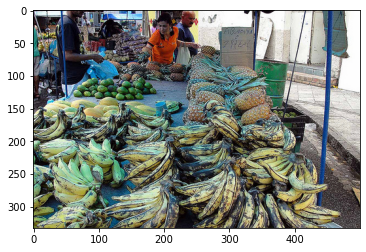

In [61]:
image_3 = imread(os.path.join(images_path, f"{sample_3['imageId']}.jpg"))
plt.imshow(image_3)

That's quite a hard crate to find....

In [62]:
predict(image_3, ["The crate is on the right of the image", "The crate is on the left of the image."])

{'The crate is on the right of the image': 0.5212783813476562,
 'The crate is on the left of the image.': 0.47872158885002136}

So the model is confused. Okay let's try some other question.

In [63]:
predict(image_3, ["A person wearing an orange shirt", "A person wearing a yellow shirt"])

{'A person wearing an orange shirt': 0.018740572035312653,
 'A person wearing a yellow shirt': 0.9812594056129456}

Just picking the dominant color huh!

In [64]:
predict(image_3, ["A person wearing an orange polo shirt", "A person wearing a yellow polo shirt"])

{'A person wearing an orange polo shirt': 0.011983999982476234,
 'A person wearing a yellow polo shirt': 0.9880160689353943}

In [69]:
predict(image_3, ["Yellow Bananas", "Orange oranges"])

{'Yellow Bananas': 0.9997391104698181,
 'Orange oranges': 0.00026087721926160157}

In [70]:
predict(image_3, ["Yellow", "Orange"])

{'Yellow': 0.7961824536323547, 'Orange': 0.20381754636764526}

So not paying attention to a lot of things. Okay, let's see something else.

In [66]:
predict(image_3, ["There are three people", "There are zero people"])

{'There are three people': 0.2617378234863281,
 'There are zero people': 0.7382622361183167}

In [67]:
predict(image_3, ["There are three people", "There are no people"])

{'There are three people': 0.18582205474376678,
 'There are no people': 0.814177930355072}

In [84]:
predict(image_3, ["pineapples", "apples"])

{'pineapples': 0.9790309071540833, 'apples': 0.020969074219465256}

Enough with bananas and people. Next sample. 

### sample 4

In [72]:
sample_4 = questions.iloc[1000]
sample_4

semantic       [{'operation': 'select', 'dependencies': [], '...
entailed       [12328113, 12328112, 12328114, 12328105, 12328...
equivalent                                            [12328111]
question       What animal is standing on the grass in front ...
imageId                                                  2407982
isBalanced                                                  True
groups         {'global': 'bird', 'local': '14-grass_standing...
answer                                                    pigeon
semanticStr    select: sidewalk (1095066)->relate: grass,in f...
annotations    {'answer': {'0': '1095071'}, 'question': {'11'...
types          {'detailed': 'relS', 'semantic': 'rel', 'struc...
fullAnswer                  The pigeon is standing on the grass.
Name: 12328111, dtype: object

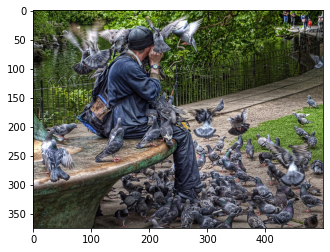

In [73]:
image_4 = imread(os.path.join(images_path, f"{sample_4['imageId']}.jpg"))
plt.imshow(image_4)

In [74]:
sample_4["fullAnswer"]

'The pigeon is standing on the grass.'

Piegons can be easily detected, but one random piegon standing on grass? Let's see.

In [75]:
predict(image_4, ["Grass", "Bananas"])

{'Grass': 0.8950425386428833, 'Bananas': 0.1049574464559555}

In [76]:
predict(image_4, ["Grass", "Trees"])

{'Grass': 0.6700586676597595, 'Trees': 0.32994136214256287}

Star Wars : A New Hope. 

In [77]:
predict(image_4, ["Piegons", "Crows"])

{'Piegons': 0.9455453753471375, 'Crows': 0.054454632103443146}

In [78]:
predict(image_4, ["Pigeons", "Pigeon"])

{'Pigeons': 0.8845987319946289, 'Pigeon': 0.11540132015943527}

This is promising....

In [79]:
predict(image_4, ["A pigeon is standing on the grass", "A monkey is standing on the grass"])

{'A pigeon is standing on the grass': 0.9991446733474731,
 'A monkey is standing on the grass': 0.0008553299703635275}

In [82]:
predict(image_4, ["A pigeon is standing on the grass", "A pigeon is flying"])

{'A pigeon is standing on the grass': 0.6576599478721619,
 'A pigeon is flying': 0.34234002232551575}

In [81]:
predict(image_4, ["standing", "flying"])

{'standing': 0.12950709462165833, 'flying': 0.8704929351806641}

Results with this sample were surprisingly good!